In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statmorph import source_morphology
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch
norm = ImageNormalize(stretch=LogStretch())
# my functions
from asymmetry_utils import calc_shape_asymmetry, create_segmentation, MaskSources, galaxy_cutout
#
import warnings
from astropy.stats import SigmaClip
import pandas as pd
import seaborn as sns

In [2]:
## you will need to change the path to wherever you clone the respository.
## For this example we work in /Users/username/...

username = 'prometheus'

## load galaxy names
names = np.loadtxt('/Users/'+username+'/asymmetry-and-machine-learning/sample_data/galaxies.txt', delimiter="\n", skiprows=0, dtype=np.str_).tolist()

## path to our vertico table
path = '/Users/'+username+'/asymmetry-and-machine-learning/sample_data/vertico_table1.fits'

table = fits.open(path)[1].data

source_morphs = {}

shape_asym = np.zeros(len(names))

for i in range(len(names)):
    
    img = fits.open('/Users/'+username+'/asymmetry-and-machine-learning/sample_data/'+names[i]+'_SPIRE_250_bkgsub.fits')[0]
    
    ## Grab our galaxies properties from the table
    new_tab = table[table['Galaxy'] == names[i]][0]
    
    ra, dec, inclination, pa = new_tab['RA'], new_tab['DEC'], new_tab['inclination'], new_tab['pa']
    
    ## Create thumnail
    cutout, centre, radius = galaxy_cutout(img.data, img.header, ra, dec, names[i], size = 5.0, centre_and_radius=True)
    
    
    ## Pixel scale
    ps = round(np.abs(3600*img.header['CDELT1']),2)
    
    ## mask nearby sources in thumbnail
    mask = MaskSources(cutout.data, names[i], path, wcs = cutout.wcs, ps=ps).disk_mask
    
    cutout.data *= mask
    
    ## Create segementation map
    segmentation_map = create_segmentation(cutout.data, sigma_clip=SigmaClip(sigma=3.5))
    
    ## if you want to use my shape asymmetry calculation
    shape_asym[i] = calc_shape_asymmetry(segmentation_map, centre, 1.5*radius)
    
    ## Use statmorph to calculate various galaxy morphology properties
    source_morphs[i] = source_morphology(cutout.data, segmentation_map, gain = 1000.0)[0]

**NOTE:**  I do not fully trust everything statmorph porduces for all of our dust maps. This is just an example to get various morphology properties. Some reasons may be the background noise and over-estimation of background asymmetry. Also, for the asymmetry, a factor of 2 in the denominator seems to be missing if we follow the Pawlik et. al. 2016 paper. I adjust that below. Statmorph seems to suggest very symmetric galaxy shapes are asymmetic (for the shape asymmetry), which I talk a bit about below.  

In [3]:
## a few features statmorph produces will be stored in a dictionary
features = {}
for i in range(len(names)):
    s = source_morphs[i]
    features[i] = {
    'Galaxy': names[i],   
    'asymmetry': s.asymmetry/2,
    'statmorph_shape_asymmetry': s.shape_asymmetry/2,
    'shape_asymmetry': shape_asym[i],
    'outer_asymmetry': s.outer_asymmetry/2,
    'gini': s.gini,
    'm20': s.m20,
    'concentration': s.concentration,
    'r50': s.r50,
    'deviation': s.deviation }

In [4]:
## pandas complained for the histograms if I do not provide the columns...
columns = [
    'Galaxy',   
    'asymmetry',
    'statmorph_shape_asymmetry',
    'shape_asymmetry',
    'outer_asymmetry',
    'gini',
    'm20',
    'concentration',
    'r50',
    'deviation' ]

In [5]:
df = pd.DataFrame(features.values(), columns = columns)

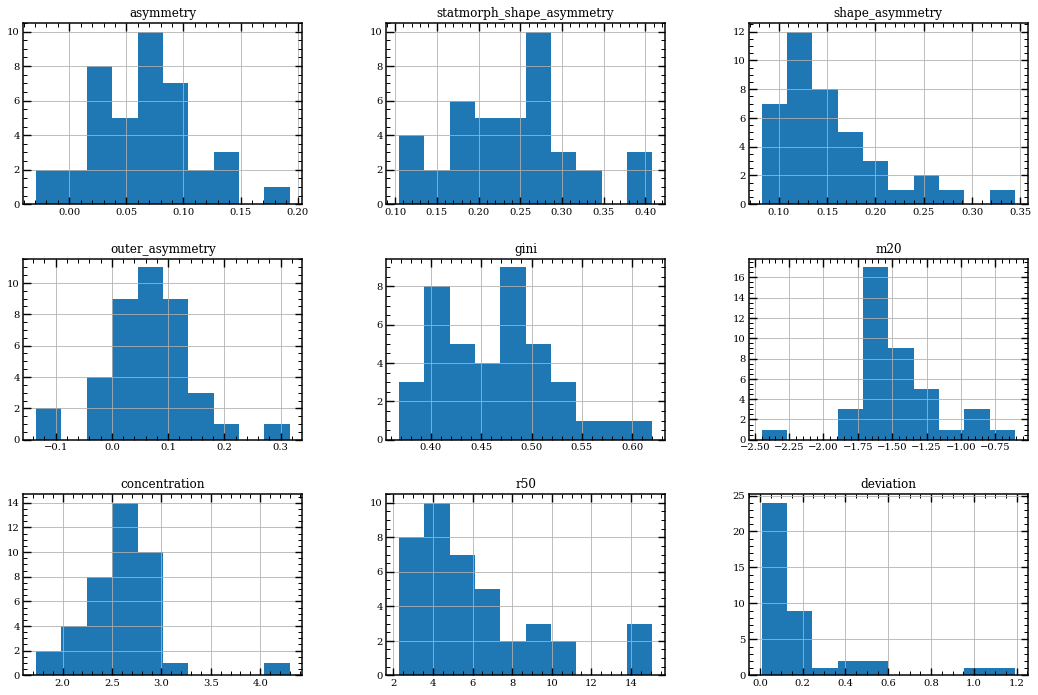

In [6]:
df.hist(figsize=(18,12))
plt.show()

<AxesSubplot:>

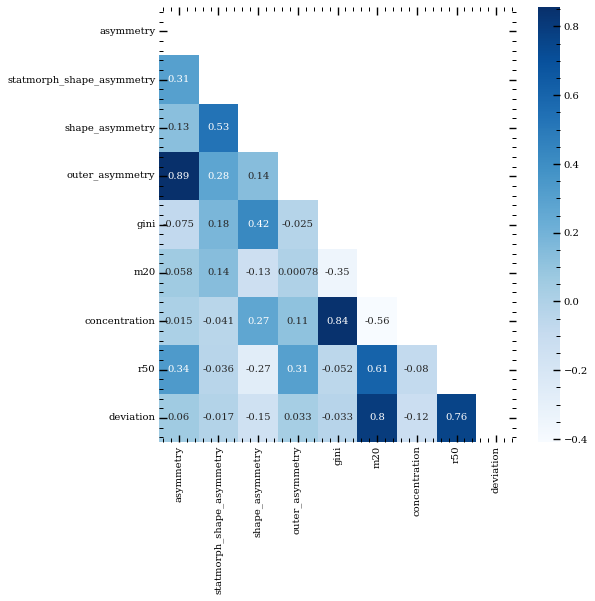

In [7]:
## correlation plot
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (8,8))
sns.heatmap(corr, annot=True, cmap = 'Blues', robust = True, mask = mask)

We see a few strong correlations between various asymmetries. Also m20, r50 and deviation, and then gini and concentration. This will be importaint for PCA. 

In [8]:
## now we use machine learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler # to standardize/normalize data set
from sklearn.cluster import KMeans # common clustering algorithm
from sklearn.decomposition import PCA # for dimensionality reduction
from sklearn.manifold import TSNE # non-linear dimensionality reduction method
from sklearn.metrics import silhouette_score # to guage global optimum
from sklearn.mixture import GaussianMixture # Find clusters of varying sizes and structure

In [9]:
## first need to remove the galaxy column to standardize
df.drop(labels='Galaxy', axis = 1, inplace=True) 
columns.remove('Galaxy')

Usually we use StandardScaler if all features are Gaussian-like, however a few are skewed, so we will use a normalizer instead

In [10]:

scaled_data = MinMaxScaler().fit_transform(df.values)

In [11]:
scaled_df = pd.DataFrame(scaled_data, columns = columns)

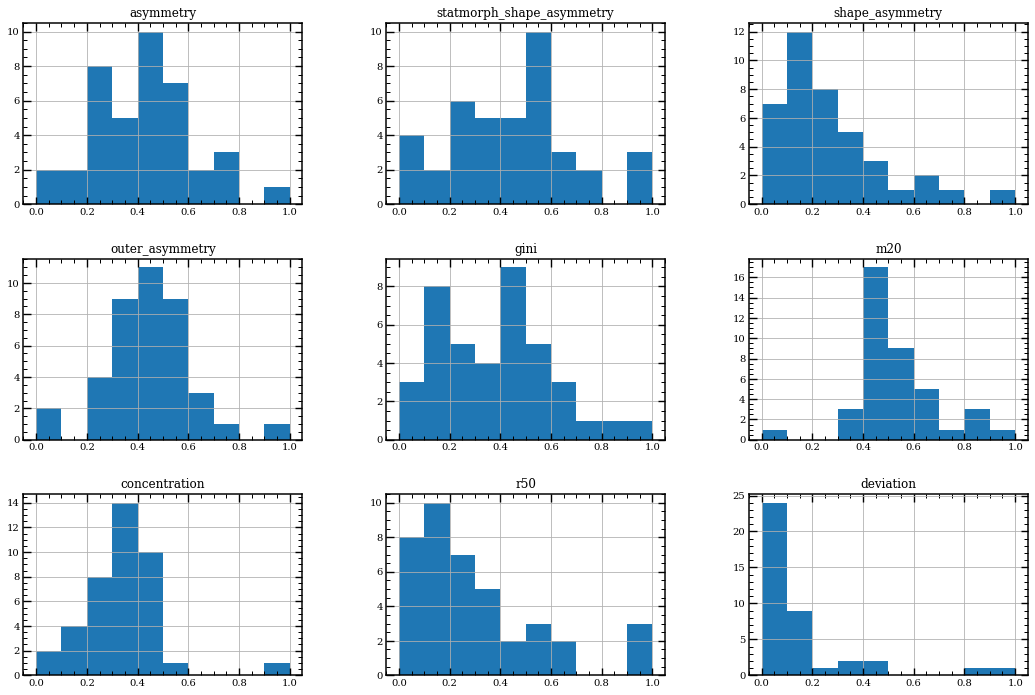

In [12]:
## We can see now that our features should all have equivalent ranges with their underlying distribution intact.
scaled_df.hist(figsize = (18,12))
plt.show()

In [13]:
## perform PCA. Keep all components to start
pca = PCA(random_state=0)
pca_comps = pca.fit_transform(scaled_df)
exp_var = pca.explained_variance_ratio_

Text(0, 0.5, 'cumulative variance')

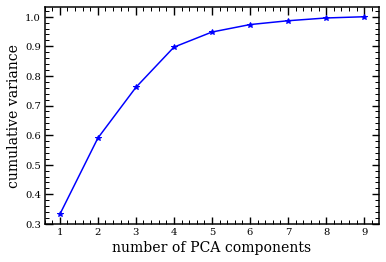

In [14]:
plt.plot(range(1,len(columns)+1), np.cumsum(exp_var), 'b-*')
plt.xlabel('number of PCA components', fontsize = 14)
plt.ylabel('cumulative variance', fontsize = 14)

In [15]:
## we can consider the number of components that explains 70 percent of the variance
n_comp = sum(~(np.cumsum(exp_var) >= .70)) + 1
print('The number of PCA components will be :', n_comp)

The number of PCA components will be : 3


In [16]:
## Run PCA again with n_comp = 3 and see what each components may represent
pca = PCA(n_components=3, random_state=0)
pca_comps = pca.fit_transform(scaled_df)

In [17]:
pca_df = pd.DataFrame(pca.components_, columns = columns, index = ['PCA1', 'PCA2', 'PCA3']).T

In [18]:
## what does each PCA component represent ?
def color_high(val):
    if val <= -0.4: # you can decide any value as per your understanding
        return 'background: red'
    elif (val > -0.4) and (val <= -0.3):
        return 'background: pink'
    elif (val >= 0.3) and (val < 0.4):
        return 'background: skyblue'
    elif val >= 0.4:
        return 'background: royalblue'

print('LARGER <------ PCA -------> SMALLER \n(blue) <------------------> (red)')    
pca_df.style.applymap(color_high)


LARGER <------ PCA -------> SMALERR 
(blue) <------------------> (red)


,PCA1,PCA2,PCA3
asymmetry,0.156390,0.370487,-0.298640
statmorph_shape_asymmetry,-0.076810,0.565953,-0.324680
shape_asymmetry,-0.268142,0.452202,-0.013425
outer_asymmetry,0.123093,0.354059,-0.245538
gini,-0.259580,0.356470,0.642084
m20,0.375665,0.034092,-0.044048
concentration,-0.186397,0.183696,0.419036
r50,0.636627,0.200004,0.265240
deviation,0.483784,0.103022,0.291157


**Note: You may not be able to see the colors if viewing on GitHub. Clone and open up the notebook**

PCA1 seems to describe the size and deviation (note: these eigenvalues form a linear combination and we will focus on the most notable ones per component). These may relate since for the deviation, we normalize by the size. This means, higher values of PCA1 indicate high deviation values meaning a galaxy has bright star forming knots. M20 is also secondary for PCA1 which traces the spatial distribution of bright clumps with increasing values indicating more 'clumpiness', so this logic holds. PCA2 clearly describes the asymmetry and most notably the shape asymmetry. PCA3 seeems to describe the distribution of dust given by gini and concentration. As gini increases we become more concentrated (i.e. ellipticals), which makes sense and thus for lower gini we have more clumpiness (which is why M20 has a negative relation for PCA3 and the opposite is true for PCA1 !). 
 
 
What is interesting is the negative relation of asymmetry for PCA3 with concentration and distribution. Since PCA3 focuses on concentration and gini, it could be that more concentrated galaxies are the ones that have been stripped (i.e. their asymmetry will decrease and are truncated) or generally have lower asymmetries. For now we can focus our attention on PCA1 and PCA2 to cluster our galaxies. 

It is also worth noting our correlation plot from before and the features being described by each component. 

In [19]:
pca12 = np.array((pca_comps.T[0], pca_comps.T[1])).T

In [20]:
## KMeans
wcss = []
for i in range(1,10):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state=0)
    km.fit(pca12)
    wcss.append(km.inertia_)

Text(0.5, 0, 'Number of Clusters')

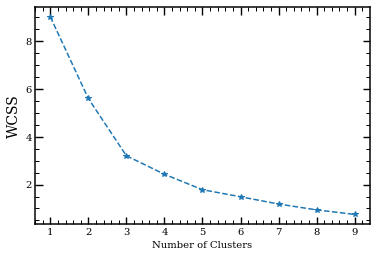

In [21]:
plt.plot(range(1,10), wcss, '*--')
plt.ylabel('WCSS', fontsize = 14)
plt.xlabel('Number of Clusters')

The choice of k is not always trivial from the Elbow Method. It looks like maybe k = 3 or k = 4 is good. We can try something like AIC/BIC as penalty or calculate silhouette score to make a better guess. 

In [22]:
## first silhouette score
score = []
for i in range(2,10):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state=0)
    km.fit(pca12)
    score.append(silhouette_score(pca12, km.labels_, metric='euclidean'))

Text(0, 0.5, 'Silhouette score')

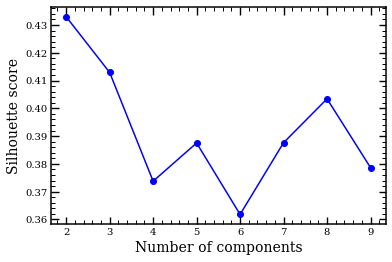

In [23]:
plt.plot(range(2,10), score, 'b-o')
plt.xlabel('Number of components', fontsize = 14)
plt.ylabel('Silhouette score', fontsize = 14)

It is rather noisy. k = 3 is the second maximum here. Let's try AIC/BIC. 

In [24]:
## GaussianMixtureModel
def get_bic_aic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans', random_state=0)
    gmm.fit(X)
    return gmm.bic(X), gmm.aic(X)

In [25]:
BIC, AIC = np.zeros((2,9))

for k in range(1,10):
    BIC[k-1], AIC[k-1] = get_bic_aic(k, pca_comps)

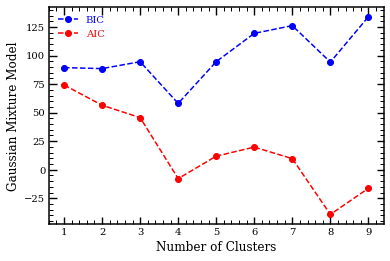

In [26]:
plt.plot(range(1,10), BIC,'bo--', label = 'BIC')
plt.plot(range(1,10), AIC,'ro--', label = 'AIC')
plt.ylabel('Gaussian Mixture Model', fontsize = 12)
plt.xlabel('Number of Clusters', fontsize = 12)
plt.legend(loc = 0, frameon = False, labelcolor = 'linecolor')

Not a super clear indication. This could be that PCA is not the best approach to create distinct groups after dimensionality reduction of our features. Another option is t-SNE. This can also be because are data set is quit small.

In [27]:
## run KMeans with 3 clusters
km = KMeans(n_clusters=3, init='k-means++', random_state=0)
km.fit(pca12)

KMeans(n_clusters=3, random_state=0)

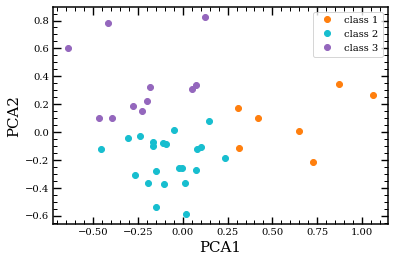

In [28]:
plt.plot(pca12.T[0][km.labels_ == 1], pca12.T[1][km.labels_ == 1], 'C1o', label = 'class 1')
plt.plot(pca12.T[0][km.labels_ == 0], pca12.T[1][km.labels_ == 0], 'C9o', label = 'class 2')
plt.plot(pca12.T[0][km.labels_ == 2], pca12.T[1][km.labels_ == 2], 'C4o', label = 'class 3')



plt.xlabel('PCA1', fontsize = 15)
plt.ylabel('PCA2', fontsize = 15)
plt.legend(loc = 0)
plt.show()

Well, we seem to have 3 clusters present that exist at different extremes of our PCA components, so this is good. In terms of the components, the seperation tells us that class 3 are the more highly asymmetric galaxies (Re: PCA2). These galaxies also tend to have smaller dust sizes. Are smaller galaxies more readily affected by ram pressure striping ? Class 1 are our symmetric and large galaxies and class 2 is somewhat in the middle of this, although, smaller sizes. If we add a 4-th class we may be able to get an additional split... 

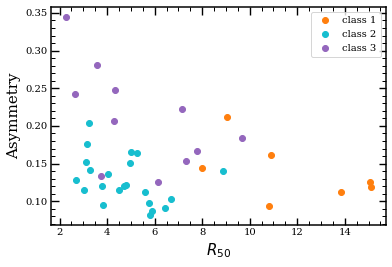

In [29]:
plt.plot(df.r50[km.labels_==1], df.shape_asymmetry[km.labels_ == 1], 'C1o', label = 'class 1')
plt.plot(df.r50[km.labels_==0], df.shape_asymmetry[km.labels_ == 0], 'C9o', label = 'class 2')
plt.plot(df.r50[km.labels_==2], df.shape_asymmetry[km.labels_ == 2], 'C4o', label = 'class 3')

plt.legend(loc = 0)
plt.xlabel('$R_{50}$', fontsize = 15)
plt.ylabel('Asymmetry', fontsize = 15)
plt.show()

There is a decent split here. Cleaner than the VIVA classes. This is a good sign, but definitely can be improved. Let's see if we can improve this with t-SNE. First some notes below:

In [30]:
np.array(names)[km.labels_ == 2]

array(['NGC4254', 'NGC4302', 'NGC4330', 'NGC4351', 'NGC4388', 'NGC4424',
       'NGC4522', 'NGC4536', 'NGC4569', 'NGC4606', 'NGC4654'], dtype='<U7')

If we look at the galaxies that exist in class 3 (printed above) we notice that the majority have some really interesting things going on (i.e. jellyfish tails and asymmetrical features). Check them out here: (http://www.astro.yale.edu/cgi-bin/viva/observations.cgi)



There are three odd instances though:

*NGC4254* --> nice spiral, statmorph seems to suggest a high shape asymmetry however. Below I print it's features.

*NGC4302* --> edge on disk, symmetrical, statmorph once again seems to suggest a high shape asymmetry.

*NGC 4536* --> symmetric spiral galaxy, has high concentration and gini which may have pushed it into this group. 

A soluton may be to remove statmorphs asymmetry measurements and use the current shape asymmetry function I created which seems to work better. Symmetrical segementation maps are giving asymmetrical values (could this be the centering algorithm ? I trust the segementation maps (See: asymmetry_visual_notebook.ipynb in this repository). We can filter and smooth the segemntation edges if anything by setting filter = True in my code, however, my shape asymmetry calculation is giving reasonable estimates.)

In [31]:
features[5]

{'Galaxy': 'NGC4254',
 'asymmetry': 0.19305123124995197,
 'statmorph_shape_asymmetry': 0.37831756869192557,
 'shape_asymmetry': 0.1835590845399346,
 'outer_asymmetry': 0.3160772317403625,
 'gini': 0.5027955818305451,
 'm20': -1.6729969308236592,
 'concentration': 2.7799238067560905,
 'r50': 9.696079364702143,
 'deviation': 0.0656425910409494}

In [32]:
features[9]

{'Galaxy': 'NGC4302',
 'asymmetry': 0.04577270527313561,
 'statmorph_shape_asymmetry': 0.32258299911190996,
 'shape_asymmetry': 0.1539456662354463,
 'outer_asymmetry': 0.03812150550768345,
 'gini': 0.5854422111142219,
 'm20': -1.4023912717997922,
 'concentration': 3.196598036226521,
 'r50': 7.334833523145547,
 'deviation': 0.08466308186666516}

In [33]:
features[26]

{'Galaxy': 'NGC4536',
 'asymmetry': 0.07581826819328902,
 'statmorph_shape_asymmetry': 0.11513782485836764,
 'shape_asymmetry': 0.125,
 'outer_asymmetry': 0.13417619091829522,
 'gini': 0.6201808903842083,
 'm20': -2.4507375313682407,
 'concentration': 4.2987866022283665,
 'r50': 6.145791275812077,
 'deviation': 0.01636276874218192}

In [34]:
tsne = TSNE(n_components=2, init = 'pca', n_iter=5000, random_state=0)
tsne_results = tsne.fit_transform(scaled_data)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [35]:
km_tsne = KMeans(n_clusters=3, init='k-means++', random_state=0)
km_tsne.fit(tsne_results)

KMeans(n_clusters=3, random_state=0)

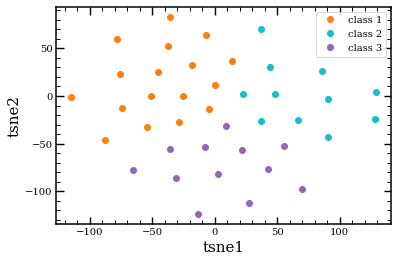

In [36]:
plt.plot(tsne_results.T[0][km_tsne.labels_ == 1], tsne_results.T[1][km_tsne.labels_ == 1], 'C1o', label = 'class 1')
plt.plot(tsne_results.T[0][km_tsne.labels_ == 0], tsne_results.T[1][km_tsne.labels_ == 0], 'C9o', label = 'class 2')
plt.plot(tsne_results.T[0][km_tsne.labels_ == 2], tsne_results.T[1][km_tsne.labels_ == 2], 'C4o', label = 'class 3')


plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(loc = 0)
plt.show()

In [37]:
np.array(names)[km_tsne.labels_ == 2]

array(['NGC4254', 'NGC4330', 'NGC4351', 'NGC4380', 'NGC4388', 'NGC4396',
       'NGC4424', 'NGC4522', 'NGC4533', 'NGC4569', 'NGC4606', 'NGC4654'],
      dtype='<U7')

In [38]:
np.array(names)[km.labels_ == 2] # equivalent to the following PCA class 3

array(['NGC4254', 'NGC4302', 'NGC4330', 'NGC4351', 'NGC4388', 'NGC4424',
       'NGC4522', 'NGC4536', 'NGC4569', 'NGC4606', 'NGC4654'], dtype='<U7')

It is relatively clear our t-SNE projection did not do a very good job separating our galaxies into distinct groups. The solution may as well have to be some admixture Model where some galaxies exist in more than 1 group. This will allow for certain 'extreme' cases to be a certain class and others to be a blend since we have a small data set with very similar features across the board.

**SUGGESTION:** It may be helpful to run this entire proccess on the HI from VIVA and use our algorithm to cluster groups to see which galaxies end up where for that sample since HI is a better indicator of stripping than the dust. The moment-0 maps can be found in the link above. It would be interesting to see what overlap the ML algorithms give. My final suggestion would be to train a classifier (i.e. supervised learning) using the dust images, giving classes based on visual inspection and which galaxies have stripping occuring OR using a neural network and providing the morphological statistics (it would be good to use as much of DustPedia as possible for this to train the network...)